In [1]:
######################
# Code for Diffusion Models
# Ref: https://github.com/dome272/Diffusion-Models-pytorch
# Code for Implementation of Imagen, Google's Text-to-Image Neural Network, in Pytorch 
# Ref: https://github.com/lucidrains/imagen-pytorch
######################

import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch import optim
import logging
from torch.utils.tensorboard import SummaryWriter

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

/vol/bitbucket/pn222/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_value = 42
torch.manual_seed(seed_value)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed_value)

In [3]:
RUN_NAME = "test"
MODE = "EXECUTE"
BASE_DIR = f"/vol/bitbucket/pn222/models/{RUN_NAME}"

In [4]:
import sys
import warnings

warnings.filterwarnings("ignore")
sys.path.append("../")
sys.path.append("../imagen/")

from helpers import *
from imagen_pytorch import Unet, Imagen, ImagenTrainer, NullUnet

In [5]:
unet1 = Unet(
    dim = 32,
    cond_dim = 1024,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
)  

unets = [unet1]

In [6]:
def train(args):
    setup_logging(args.run_name, BASE_DIR)
    device = args.device
    train_dataloader, test_dataloader = args.dataloaders ; random_batch_idx = [12]
    logger = SummaryWriter(os.path.join(f"{BASE_DIR}/runs", args.run_name))
    epoch = 0
    
    k = 1
    trainer = ImagenTrainer(imagen, lr=args.lr, verbose=False).cuda()
    try:
        ckpt_path = os.path.join(f"{BASE_DIR}/models", args.run_name, f"ckpt_{k}.pt")
        ckpt_trainer_path = os.path.join(f"{BASE_DIR}/models", args.run_name, f"ckpt_trainer_{k}.pt")
        checkpoint = torch.load(ckpt_path)
        trainer.load(ckpt_trainer_path)        
        start_epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        logging.info(f"Resuming training from epoch: {start_epoch+1} for unet_{k}")  
        if (start_epoch+1) >= args.epochs: 
            logging.info(f"No more epochs to train for unet_{k}")
        epoch = start_epoch+1
    except FileNotFoundError:
        start_epoch = -1
        loss = None
        logging.info(f"Starting training from scratch for unet_{k}")
        epoch = 0
    
    for epoch in range(start_epoch+1, args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        if args.shuffle_every_epoch:
            _ = len(train_dataloader) ; train_dataloader.create_batches(args.batch_size, False)
        pbar = tqdm(train_dataloader)
        for i, (img_64, _, img_tp) in enumerate(pbar):
            img_64 = img_64[:, 0:1, :, :]
            cond_embeds = img_64.reshape(img_64.shape[0], -1).float().cuda()
            img_tp = img_tp.float().cuda()
            
            loss = trainer(images=img_tp,
                           continuous_embeds=cond_embeds,
                           unet_number=k)
            trainer.update(unet_number=k)
    
            pbar.set_postfix({f"MSE_{k}":loss})
            logger.add_scalar(f"MSE_{k}",loss, global_step=epoch*len(train_dataloader)+i)
    
        checkpoint = {
            'epoch': epoch,
            'loss': loss
        }

        logging.info(f"Completed epoch {epoch}.")
        
        if (MODE == "EXPERIMENT") or \
           (MODE == "EXECUTE" and ((epoch % 5 == 0) or (epoch == (args.epochs-1)))):
            trainer.save(os.path.join(f"{BASE_DIR}/models", args.run_name, f"ckpt_trainer_{k}.pt"))
            torch.save(checkpoint, os.path.join(f"{BASE_DIR}/models", args.run_name, f"ckpt_{k}.pt"))

    if args.sample:
        logging.info(f"Starting sampling for epoch {epoch}:") ; _ = len(test_dataloader)               
        random_batch = test_dataloader.random_idx[random_batch_idx][0]
        img_64, _, img_tp = test_dataloader.get_batch(random_batch)
        img_64 = img_64[:, 0:1, :, :]
        
        cond_embeds = img_64.reshape(img_64.shape[0], -1).float().cuda()
        ema_sampled_images = imagen.sample(
                    batch_size = img_64.shape[0],          
                    cond_scale = 3.,
                    continuous_embeds=cond_embeds
            )
        save_images_v2(test_dataloader, img_tp, ema_sampled_images, os.path.join(f"{BASE_DIR}/results", args.run_name, f"{epoch}_ema.jpg"))
        logging.info(f"Completed sampling for epoch {epoch}.")

In [7]:
import argparse

class DDPMArgs:
    def __init__(self):
        pass
    
args = DDPMArgs()
args.run_name = RUN_NAME
args.epochs = 1
args.batch_size = 16
args.image_size = 64 ; args.o_size = 64 ; args.n_size = 128 ;
args.continuous_embed_dim = 64*64*1
args.dataset_path = f"/vol/bitbucket/pn222/satellite/dataloader/{args.o_size}_PRP"
args.device = "cuda"
args.lr = 3e-4
args.sample = True
args.datalimit = False
args.augment = True
args.mode = "tp"
args.shuffle_every_epoch = False

args.dataloaders = get_satellite_data(args)
logging.info(f"Dataset loaded")

100%|███████████████████████████████████████████| 51/51 [00:09<00:00,  5.15it/s]
09:47:32 - INFO: Dataset loaded


09:47:33 - INFO: Starting training from scratch for unet_1
09:47:33 - INFO: Starting epoch 0:
100%|████████████████████████| 2478/2478 [08:56<00:00,  4.62it/s, MSE_1=0.00354]
09:56:34 - INFO: Completed epoch 0.
09:56:41 - INFO: Starting sampling for epoch 0:
Sampling: 100%|███████████████████████████████| 250/250 [00:28<00:00,  8.86it/s]
1it [00:28, 28.57s/it]


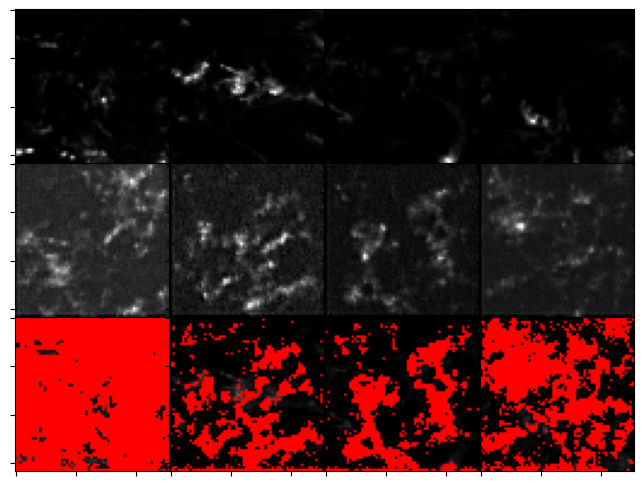

09:57:11 - INFO: Completed sampling for epoch 0.


In [8]:
imagen = Imagen(
    unets = unets,
    image_sizes = (64),
    timesteps = 250,
    cond_drop_prob = 0.1,
    condition_on_continuous = True,
    continuous_embed_dim = args.continuous_embed_dim,
)

train(args)